In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchtext

from collections import Counter
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence, pad_packed_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab

from tqdm.notebook import tqdm
from torch.nn import BCEWithLogitsLoss
from torch.nn import GRU, LSTM, RNN

# Przygotowywanie zbioru danych

Wykorzystamy zbiór danych "IMDB movie review sentiment classification". Poniżej definiujemy funkcje do obróbki danych i ułożenia ich w batche.

In [2]:
from torchtext.utils import download_from_url, extract_archive
from torchtext.data.datasets_utils import _RawTextIterableDataset
from torchtext.data.datasets_utils import _wrap_split_argument
from torchtext.data.datasets_utils import _add_docstring_header
from torchtext.data.datasets_utils import _create_dataset_directory
import io

URL = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
MD5 = '7c2ac02c03563afcf9b574c7e56c153a'

NUM_LINES = {
    'train': 25000,
    'test': 25000,
}

_PATH = 'aclImdb_v1.tar.gz'

DATASET_NAME = "IMDB"

@_create_dataset_directory(dataset_name=DATASET_NAME)
@_wrap_split_argument(('train', 'test'))
def IMDB(root, split):
    def generate_imdb_data(key, extracted_files, root):
        root_path = os.path.abspath(root)
        for fname in extracted_files:
            relative_fname = fname[len(root_path):]
            if 'urls' in relative_fname:
                continue
            elif key in relative_fname and ('pos' in relative_fname or 'neg' in relative_fname):
                with io.open(fname, encoding="utf8") as f:
                    label = 'pos' if 'pos' in relative_fname else 'neg'
                    yield label, f.read()
    dataset_tar = download_from_url(URL, root=root,
                                    hash_value=MD5, hash_type='md5')
    extracted_files = extract_archive(dataset_tar)
    iterator = generate_imdb_data(split, extracted_files, root)
    return _RawTextIterableDataset(DATASET_NAME, NUM_LINES[split], iterator)


In [3]:
def yield_tokens(data_iter, tokenizer):
    for _, text in data_iter:
        yield tokenizer(text)


# Skip the first two lines 
train_iter = list(IMDB(split="train"))
test_iter = list(IMDB(split="test"))
tokenizer = get_tokenizer("basic_english")


vocab = torchtext.vocab.build_vocab_from_iterator(
    yield_tokens(train_iter, tokenizer),
    min_freq=10,
    specials=("<unk>", "<BOS>", "<EOS>", "<PAD>"),
)
vocab.set_default_index(vocab["<unk>"])

text_transform = (
    lambda x: [vocab["<BOS>"]]
    + [vocab[token] for token in tokenizer(x)]
    + [vocab["<EOS>"]]
)
label_transform = lambda x: 1 if x == "pos" else 0


def collate_batch(batch):
    label_list, text_list = [], []
    sentence_lens = []
    for (_label, _text) in batch:
        label_list.append(label_transform(_label))
        processed_text = torch.tensor(text_transform(_text))
        text_list.append(processed_text)
        sentence_lens.append(len(processed_text))

    packed_padded = pad_sequence(text_list, padding_value=3.0)

    return torch.tensor(label_list), packed_padded, sentence_lens

Poniżej definujemy model do analizy sentymentu oparty na architekturze RNN.

In [ ]:


class TextClassificationModel(torch.nn.Module):
    def __init__(self, vocab, embed_size, hidden_size, rnn_class):
        super().__init__()
        self.embedding = torch.nn.Embedding(len(vocab), embed_size, padding_idx=3)
        self.rnn = rnn_class(embed_size, hidden_size)
        self.output_layer = torch.nn.Linear(hidden_size, 1)

    def forward(self, x, sentence_lens):
        x = self.embedding(x)
        x = pack_padded_sequence(x, sentence_lens, enforce_sorted=False)
        if self.rnn.__class__ == LSTM:
            outputs, (c, h) = self.rnn(x)
        else:
            outputs, h = self.rnn(x)
        # outputs, _ = pad_packed_sequence(outputs)

        return self.output_layer(h[0]).squeeze(1)


def evaluate(model, loader):
    correct_num = 0
    total_num = 0
    for labels, text, lens in loader:
        preds = (model(text.cuda(), lens) > 0.0).cpu()
        correct_num += (preds == labels.float()).sum()
        total_num += len(preds)
    return correct_num / total_num


def train_model(batch_size, lr, embed_size, hidden_size, rnn_class):
    print(
        f"==== bs={batch_size}, lr={lr}, es={embed_size}, hs={hidden_size}, {rnn_class.__name__} ===="
    )
    train_dataloader = DataLoader(
        train_iter, batch_size=batch_size, shuffle=True, collate_fn=collate_batch
    )
    test_dataloader = DataLoader(
        test_iter, batch_size=batch_size, shuffle=False, collate_fn=collate_batch
    )

    classifier = TextClassificationModel(
        vocab, embed_size, hidden_size, rnn_class
    ).cuda()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
    loss_fn = BCEWithLogitsLoss()

    test_accs = []
    train_losses = []
    for epoch in range(50 + 1):
        epoch_train_loss = 0.0
        num_batches = len(train_dataloader)
        for labels, text, lens in tqdm(train_dataloader):
            preds = classifier(text.cuda(), lens)
            loss_val = loss_fn(preds.cuda(), labels.float().cuda())
            loss_val.backward()
            torch.nn.utils.clip_grad_norm_(classifier.parameters(), 1.0)

            optimizer.step()
            optimizer.zero_grad()
            epoch_train_loss += loss_val.item()
        train_losses += [epoch_train_loss / num_batches]

        if epoch % 1 == 0:
            acc = evaluate(classifier, test_dataloader)
            print(epoch, acc)
            test_accs += [acc]
    acc = evaluate(classifier, test_dataloader)
    return train_losses, test_accs


results = {}
results["RNN"] = train_model(128, 0.0001, 1024, 256, RNN)
results["LSTM"] = train_model(128, 0.001, 512, 1024, LSTM)
results["GRU"] = train_model(128, 0.001, 512, 1024, GRU)

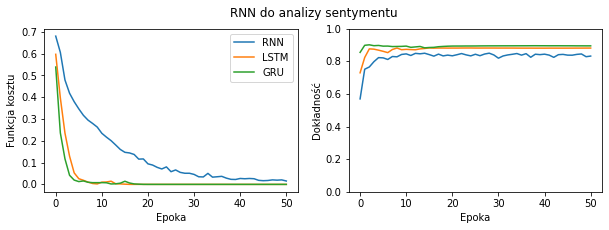

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

fig.suptitle("RNN do analizy sentymentu")

for name, (train_losses, test_accs) in results.items():
    ax1.plot(np.arange(51), train_losses, label=name.split("_")[0])
    ax1.legend()
    ax1.set_xlabel("Epoka")
    ax1.set_ylabel("Funkcja kosztu")
    ax2.plot(np.arange(51), test_accs)
    ax2.set_xlabel("Epoka")
    ax2.set_ylabel("Dokładność")
    ax2.set_ylim(0, 1)